In [1335]:
import matplotlib as pyplot
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [1336]:
df = pd.read_pickle('data/games_with_odds.pkl')

In [1337]:
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df = df.sort_values(['team_code', 'date'])

In [1338]:
game_cols = ['gid', 'status_ind', 'date', 'weekday', 'clouds', 'hp_ump', 'temp', 'wind_dir', 'wind_speed',
             'over_under', 'league', 'away_time_diff', 'division_game', 'game_type']
game_df = df[game_cols].drop_duplicates('gid')

In [1339]:
team_group = ['season', 'team_code']
shift_cols = ['batting_avg', 'batting_obp', 'batting_ops', 'pitching_era', 'wins', 'loss']

team_df = (df.groupby(team_group)[shift_cols].transform(
        lambda x: x.shift())).astype(float)
team_df['team_runs'] = df['batting_r']
team_df['team_win_pct'] = team_df['wins'] / (team_df['wins'] + team_df['loss'])
team_df['team_last_5_win_pct']  = df.groupby(team_group)['wins'].transform(
    lambda x: (x.astype(int).shift() - x.astype(int).shift(6)) / 5)
team_df['season_complete_pct'] = (team_df['wins'] + team_df['loss']) / 162

no_shift_cols = ['us_line', 'decimal_line']
team_df[no_shift_cols] = df[no_shift_cols]

gb_cols = ['games_back', 'games_back_wildcard']
team_df[gb_cols] = df.groupby(team_group)[gb_cols].transform(
    lambda x: x.shift().ffill())

In [1340]:
starter_group = ['season', 'team_code', 'starter_name_display_first_last']
starter_cols = ['starter_w', 'starter_l', 'starter_s_bb', 'starter_s_ip',
                'starter_s_h', 'starter_s_so', 'starter_era']
starter_df = (df.groupby(starter_group)[starter_cols].transform(
    lambda x: x.shift())).astype(float)
starter_df['starter_s_hr'] = df.groupby(starter_group)['starter_hr'].transform(
    lambda x: x.astype(int).shift().cumsum())
starter_df['starter_s_game_score'] = df.groupby(starter_group)['starter_game_score'].transform(
    lambda x: x.astype(float).shift().expanding().mean())
starter_df['starter_hr_ip'] = starter_df['starter_s_hr'] / starter_df['starter_s_ip']
starter_df['starter_win_pct'] = starter_df['starter_w'] / (starter_df['starter_w'] + starter_df['starter_l'])
starter_df['starter_last_5_win_pct']  = df.groupby(starter_group)['starter_w'].transform(
    lambda x: (x.astype(int).shift() - x.astype(int).shift(6)) / 5)
starter_df['starter_s_whip'] = (starter_df['starter_s_bb'] + starter_df['starter_s_h'])/ starter_df['starter_s_ip']
starter_df['starter_s_soip'] = (starter_df['starter_s_so'])/ starter_df['starter_s_ip']

In [1341]:
add_cols = ['team_code', 'starter_name_display_first_last']

hix = (df['home_away'] == 'home')
home_df = pd.concat([df.loc[hix, add_cols], team_df[hix], starter_df[hix]], axis=1)
home_df = home_df.rename(columns=lambda x: 'home_{}'.format(x))
home_df = pd.concat([df.loc[hix, 'gid'], home_df], axis=1)

aix = (df['home_away'] == 'away')
away_df = pd.concat([df.loc[aix, add_cols], team_df[aix], starter_df[aix]], axis=1)
away_df = away_df.rename(columns=lambda x: 'away_{}'.format(x))
away_df = pd.concat([df.loc[aix, 'gid'], away_df], axis=1)

In [1342]:
train_df = pd.merge(game_df, pd.merge(home_df, away_df, on='gid'), on='gid').fillna(0)

In [1343]:
ignore = ['gid', 'status_ind', 'date', 'home_team_code', 'home_wins', 'home_loss',
    'home_starter_name_display_first_last', 'home_starter_w',
    'home_starter_l', 'home_starter_s_bb', 'home_starter_s_ip',
    'home_starter_s_h', 'home_starter_s_so', 'home_starter_s_hr',
    'away_team_code', 'away_wins', 'away_loss', 'away_starter_name_display_first_last',
    'away_starter_w', 'away_starter_l', 'away_starter_s_bb', 'away_starter_s_ip',
    'away_starter_s_h', 'away_starter_s_so', 'away_starter_s_hr', 'home_team_runs', 'away_team_runs']

ignore = ignore + ['home_us_line', 'home_decimal_line', 'away_us_line', 'away_decimal_line']

cats = ['weekday', 'clouds', 'hp_ump', 'wind_dir', 'league', 'game_type']
num = list(set(train_df.columns) - set(cats + ignore))

In [1344]:
x = pd.concat([train_df[num].astype(float), pd.get_dummies(train_df[cats])], axis=1)

In [1345]:
y = (train_df['home_team_runs'].astype(int) > train_df['away_team_runs'].astype(int)).astype(int)

In [1346]:
kf = KFold(n_splits=10, shuffle=False)
# skf = StratifiedKFold(n_splits=10)

In [1347]:
dtrain = xgb.DMatrix(x, label=y, feature_names=x.columns)

In [1348]:
param = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'binary:logistic',
}
history = xgb.cv(params=param, dtrain=dtrain, num_boost_round=50, folds=kf.split(x),
                 metrics=['error', 'auc'], verbose_eval=1,
                 early_stopping_rounds=5)

[0]	train-auc:0.602026+0.00228487	train-error:0.416786+0.00188513	test-auc:0.56476+0.0144776	test-error:0.448647+0.0119228
[1]	train-auc:0.612775+0.00204637	train-error:0.411373+0.00203898	test-auc:0.571488+0.0149743	test-error:0.441677+0.014324
[2]	train-auc:0.618524+0.0017792	train-error:0.408674+0.00205827	test-auc:0.57475+0.0143713	test-error:0.441818+0.0151817
[3]	train-auc:0.622427+0.00166296	train-error:0.406297+0.00264768	test-auc:0.577255+0.0136595	test-error:0.43689+0.0152834
[4]	train-auc:0.626023+0.00178118	train-error:0.403864+0.00133143	test-auc:0.579129+0.0147274	test-error:0.435341+0.0140419
[5]	train-auc:0.628647+0.00180454	train-error:0.402565+0.00181093	test-auc:0.579463+0.0136535	test-error:0.435482+0.0135399
[6]	train-auc:0.631322+0.0016983	train-error:0.40011+0.00194626	test-auc:0.581367+0.0145577	test-error:0.432596+0.0167201
[7]	train-auc:0.633718+0.00163696	train-error:0.398639+0.00262536	test-auc:0.582538+0.0157974	test-error:0.432807+0.0163339
[8]	train-auc:0

In [1349]:
best_acc = history['test-error-mean'].min()
best_acc_iter = history['test-error-mean'].idxmin()
best_auc = history['test-auc-mean'].max()
best_auc_iter = history['test-auc-mean'].idxmax()
print("""naive accuracy: {}
best test accuracy: {} on {} boosting iterations
best test auc: {} on {} boosting iterations""".format(y.mean(),
                                                      1- best_acc,
                                                      best_acc_iter,
                                                      best_auc,
                                                      best_auc_iter))

naive accuracy: 0.5347412882787751
best test accuracy: 0.5733181 on 16 boosting iterations
best test auc: 0.5873204000000001 on 16 boosting iterations


In [1350]:
cv_preds = []
for train_ix, test_ix in kf.split(x):
    dtrain_k = xgb.DMatrix(x.iloc[train_ix], label=y.iloc[train_ix], feature_names=x.columns)
    dtest_k =xgb.DMatrix(x.iloc[test_ix], feature_names=x.columns)
    bst = xgb.train(params=param, dtrain=dtrain_k, num_boost_round=best_auc_iter)
    cv_preds.append({'cv_index': test_ix, 'cv_pred': bst.predict(dtest_k)})

In [1351]:
cv_df = pd.concat([pd.DataFrame(f) for f in cv_preds], ignore_index=True)
cv_df = cv_df.sort_values('cv_index')
cv_df['pred_class'] = cv_df['cv_pred'].apply(
    lambda x: 1 if x >= 0.5 else 0)
cv_df['home_wins'] = y
cv_df['pred_bin'] = pd.cut(cv_df['cv_pred'], bins=np.arange(0.0, 1.0, 0.1))
cv_df['implied_probability'] = train_df['home_us_line'].apply(
    lambda x: x / (x - 100) if x < 0 else 100/(x+100))
cv_df['line_bin'] = pd.cut(cv_df['implied_probability'], bins=np.arange(0.0, 1.0, 0.1))

print('cv accuracy: {}'.format(accuracy_score(y_pred=cv_df['pred_class'], y_true=y)))
print('cv auc: {}'.format(roc_auc_score(y, cv_df['cv_pred'])))

line_acc = accuracy_score((train_df['home_us_line'] < train_df['away_us_line']).astype(int), y)
line_auc = roc_auc_score(y, cv_df['implied_probability'])
print('line favorite accuracy: {}'.format(line_acc))
print('line favorite auc: {}'.format(line_auc))

pd.concat([cv_df.groupby('pred_bin')['home_wins'].agg(['count', 'mean']),
cv_df.groupby('line_bin')['home_wins'].agg(['count', 'mean'])], axis=1)

cv accuracy: 0.5719112988384372
cv auc: 0.5852677496840561
line favorite accuracy: 0.5728968673002464
line favorite auc: 0.5962562540381887


,count,mean,count,mean
"(0.0, 0.1]",0,NaN,0,NaN
"(0.1, 0.2]",0,NaN,0,NaN
"(0.2, 0.3]",0,NaN,18,0.111111
"(0.3, 0.4]",406,0.359606,587,0.344123
"(0.4, 0.5]",4200,0.450714,3622,0.448095
"(0.5, 0.6]",7899,0.566274,6278,0.545397
"(0.6, 0.7]",1698,0.637220,3303,0.626097
"(0.7, 0.8]",2,1.000000,396,0.696970
"(0.8, 0.9]",0,NaN,1,1.000000


In [1352]:
bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=best_auc_iter)

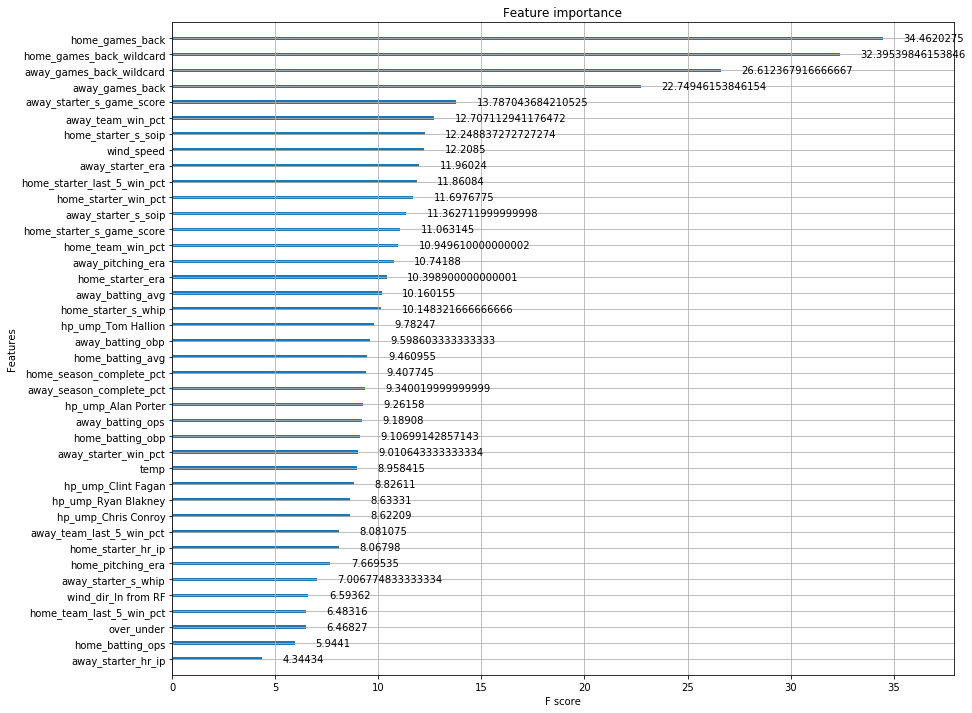

In [1353]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = [14, 12]
xgb.plot_importance(bst, importance_type='gain')